# Seq2seq Translation
---

## Step 0. 설계
---

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from konlpy.tag import Mecab

import time
import re
import os
import io

from tqdm import tqdm    # tqdm
import random

print(tf.__version__)

2.4.1


In [2]:
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




In [3]:
workspace_path = os.getenv('HOME') + '/workspace/aiffel-gd-nlp/GD08_seq2seq_translation'
workspace_path

'/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation'

In [4]:
!pwd

/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD08_seq2seq_translation


## Step 1. 데이터 다운로드
---

아래 링크에서 `korean-english-park.train.tar.gz` 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [5]:
# !tar -xvf {workspace_path}/data/korean-english-park.dev.tar -C {workspace_path}/data
# !tar -xvf {workspace_path}/data/korean-english-park.test.tar -C {workspace_path}/data
# !tar -xvf {workspace_path}/data/korean-english-park.train.tar -C {workspace_path}/data

In [6]:
# !ls ./data

## Step 2. 데이터 정제
---

### 1. 데이터 불러오기

In [7]:
def load_file(path):
    with open(path, "r") as f:
        raw = f.read().splitlines()
    
    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]:
        print(">>", sen)
    
    print()
    return raw

In [8]:
ko_train = load_file(f'{workspace_path}/data/korean-english-park.train.ko')
ko_train += load_file(f'{workspace_path}/data/korean-english-park.dev.ko')
ko_train += load_file(f'{workspace_path}/data/korean-english-park.test.ko')
print(len(ko_train))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.

Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.

Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 

In [9]:
en_train = load_file(f'{workspace_path}/data/korean-english-park.train.en')
en_train += load_file(f'{workspace_path}/data/korean-english-park.dev.en')
en_train += load_file(f'{workspace_path}/data/korean-english-park.test.en')
print(len(en_train))

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.

Data Size: 1000
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war.
>> The head of the U.N. weapons inspectio

### 2. 중복 제거

#### A. 함수 정의

In [10]:
def get_duplicated_index(raw):
    """
    주어진 문장 셋에서 중복된 문장의 인덱스를 반환합니다.
    같은 문장이 2회 이상 반복되었을 때, 두번째 이후의 인덱스를 모아 반환합니다.
    
    Args:
        raw (list): 문장 데이터를 담고 있는 리스트
    
    Returns:
        list: raw에서 중복된 데이터의 인덱스를 모은 리스트
    """
    clear_set = set()
    removed_index = []
    cnt_old = 0
    
    for i, sen in enumerate(raw):
        clear_set.add(sen)
        cnt_new = len(clear_set)
        
        if cnt_new == cnt_old:
            removed_index.append(i)
        cnt_old = cnt_new
    
    return removed_index

In [11]:
def remove_by_indexs(raw, indexs):
    """
    주어진 문장 셋에서 특정 index에 위치한 데이터들을 제거한 문장 셋을 반환한다.
    
    Args:
        raw (list): 문장 데이터를 담고 있는 리스트
        indexs (list): raw에서 제거할 원소들의 인덱스를 담고 있는 리스트
        
    Returns:
        list: raw에서 indexs에 위치한 원소들을 제거한 데이터 리스트
    """
    return [ sen for i, sen in enumerate(raw) if i not in indexs ]

#### B. 데이터 중복 제거
- ko 데이터 중복 제거

In [12]:
removed_index = get_duplicated_index(ko_train)
cleaned_ko_train = remove_by_indexs(ko_train, removed_index)
cleaned_en_train = remove_by_indexs(en_train, removed_index)
len(cleaned_ko_train), len(cleaned_en_train)

(80558, 80558)

In [13]:
start = removed_index[0]-1
end = removed_index[0]+2
for ko, en in zip(cleaned_ko_train[start:end], cleaned_en_train[start:end]):
    print(f'ko : {ko}')
    print(f'en : {en}')
    print()

ko : "자동화 기술은 우체국에서, 그리고 업무가 끝난 후 사무실 경비에, 그리고 의심스러운 차량을 수색하는 데 사용될 수 있습니다."
en : “It could be used in post offices, in surveillance of offices after hours and to inspect suspicious cars.”

ko : 그와 동시 에 노동 비용은 더욱 상승하고 있습니다." 라고 말했다.
en : At the same time, labor costs are more and more.”

ko : "산업용 로보트 분야에서 2000년은 최상의 해였습니다." 라고 이 스웨덴인은 덧붙혀 말했다.
en : “For industrial robots, 2000 was the best year ever,” added the Swede.



- en 데이터 중복 제거

In [14]:
removed_index = get_duplicated_index(cleaned_en_train)
cleaned_en_train = remove_by_indexs(cleaned_en_train, removed_index)
cleaned_ko_train = remove_by_indexs(cleaned_ko_train, removed_index)
len(cleaned_ko_train), len(cleaned_en_train)

(77747, 77747)

In [15]:
start = removed_index[0]-1
end = removed_index[0]+2
for ko, en in zip(cleaned_ko_train[start:end], cleaned_en_train[start:end]):
    print(f'ko : {ko}')
    print(f'en : {en}')
    print()

ko : 중국 쓰촨성 지역을 포함, 중남부 지역에 폭우가 쏟아져 55명이 숨지고 100만명의 이재민이 발생했다고 중국 관영통신이 15일(현지시가) 보도했다.
en : BEIJING, China (CNN) &#8212; Flooding has killed 55 people and forced more than a million to flee their homes across a stretch of southwestern China, including the earthquake-ravaged Sichuan province, state media reported Sunday.

ko : 신화통신은 14일 오후까지 중국 당국의 공식 집계에따르면 이번 지진으로 6면9170명이 사망하고 37만4159명의 이재민과 1만428명의 실종자가 발생했다고 보도했다.
en : By Saturday afternoon, the official death toll from the quake had risen to 69,170, Xinhua said. Another 374,159 people were injured and 17,428 are still missing.

ko : 미국 민주당의 대선후보인 버락 오바마 상원의원이 흑인 아버지들에게 가정을 돌볼 것을 촉구했다.
en : CHICAGO, Illinois (CNN) Barack Obama celebrated Father's Day by calling on black fathers, who he said are "missing from too many lives and too many homes," to become active in raising their children.



### 3. 정제하기

#### A. 함수 정의
- 정규식을 이용하여 데이터를 정제한다.
    - 사용할 특수문자(`?`, `.`, `!`, `,`)의 전후로 공란을 추가한다.
    - 연달아 등장하는 공란("  ")을 하나의 공란으로 변경한다.
    - 한글/영어/특수문자(`?`, `.`, `!`, `,`)를 제외한 문자를 제거한다.

In [16]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    """
    아래의 조건에 따라 데이터를 정제한다.
    1. 사용할 특수문자(`?`, `.`, `!`, `,`)의 전후로 공란을 추가한다.
    2. 연달아 등장하는 공란("  ")을 하나의 공란으로 변경한다.
    3. 한글/영어/특수문자(`?`, `.`, `!`, `,`)를 제외한 문자를 제거한다.
    4. 입력받은 파라미터 `s_token`이 False가 아니라면 문자의 시작에 <start> 토큰을 삽입한다.
    5. 입력받은 파라미터 `e_token`이 False가 아니라면 문자의 끝에 <end> 토큰을 삽입한다.
    
    Args:
        sentence (str): 정제할 문장
        s_token (bool): default=False, True라면 정제된 문장의 시작 지점에 <start> 토큰을 삽입힌다.
        e_token (bool): default=False, True라면 정제된 문장의 끝 지점에 <end> 토큰을 삽입힌다.

    Returns:
        str : 정제된 문장
    """
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

#### B. Train 데이터 정제

In [17]:
preprocessed_ko_train = [preprocess_sentence(sen) for sen in cleaned_ko_train]
preprocessed_en_train = [preprocess_sentence(sen, s_token=True, e_token=True) 
                         for sen in cleaned_en_train]

In [18]:
print(f'before preprocess : {cleaned_ko_train[0]}')
print(f'after preprocess : {preprocessed_ko_train[0]}')

before preprocess : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
after preprocess : 개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?


In [19]:
print(f'before preprocess : {cleaned_en_train[0]}')
print(f'after preprocess : {preprocessed_en_train[0]}')

before preprocess : Much of personal computing is about "can you top this?"
after preprocess : <start> much of personal computing is about can you top this ? <end>


### 4. 토큰화

#### A. 함수 정의

In [20]:
def tokenize(kor_corpus, eng_corpus, vocab_size=10000, max_len=40):
    # english tokenizer
    eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',
                                                          num_words=vocab_size,
                                                          oov_token='<unk>')
    eng_tokenizer.fit_on_texts(eng_corpus)
    eng_tokenizer.index_word.update({ 0 : '<pad>'})
    
    # korean tokenizer
    mecab = Mecab()
    morpheme = [ " ".join(mecab.morphs(sen)) for sen in kor_corpus ]
    kor_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters="", 
                                                          num_words=vocab_size,
                                                          oov_token='<unk>')
    kor_tokenizer.fit_on_texts(morpheme)
    kor_tokenizer.index_word.update({ 0 : '<pad>'})
    
    # tokenize
    eng_tensor = eng_tokenizer.texts_to_sequences(eng_corpus)
    kor_tensor = kor_tokenizer.texts_to_sequences(morpheme)
    
    kor_tensor_reduced = []
    eng_tensor_reduced = []
    
    for kor_sen, eng_sen in zip(kor_tensor, eng_tensor):
        if len(kor_sen) <= max_len and len(eng_sen) <= max_len:
            kor_tensor_reduced.append(kor_sen)
            eng_tensor_reduced.append(eng_sen)
    
    # add padding
    kor_tensor_reduced = tf.keras.preprocessing.sequence.pad_sequences(kor_tensor_reduced, padding='post')
    eng_tensor_reduced = tf.keras.preprocessing.sequence.pad_sequences(eng_tensor_reduced, padding='post')

    return kor_tensor_reduced, kor_tokenizer, eng_tensor_reduced, eng_tokenizer

#### B. Train 데이터 토큰화

In [21]:
vocab_size = 50000
enc_train, enc_tokenizer, dec_train, dec_tokenizer = tokenize(preprocessed_ko_train,
                                                              preprocessed_en_train,
                                                              vocab_size=vocab_size)
enc_train.shape, dec_train.shape

((61327, 40), (61327, 40))

In [22]:
print(f'encoded : {enc_train[0]}')
for enc in enc_train[0]:
    if enc == 0:
        break
    print(f'>>> {enc} : {enc_tokenizer.index_word[enc]}')

encoded : [  658   614   519   158     7  1381   857     9   695   149 31493    41
    14  3435   457     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
>>> 658 : 개인
>>> 614 : 용
>>> 519 : 컴퓨터
>>> 158 : 사용
>>> 7 : 의
>>> 1381 : 상당
>>> 857 : 부분
>>> 9 : 은
>>> 695 : 이것
>>> 149 : 보다
>>> 31493 : 뛰어날
>>> 41 : 수
>>> 14 : 있
>>> 3435 : 느냐
>>> 457 : ?


In [23]:
print(f'encoded : {dec_train[0]}')
for enc in dec_train[0]:
    if enc == 0:
        break
    print(f'>>> {enc} : {dec_tokenizer.index_word[enc]}')

encoded : [   5  262    8 1175 7728   17   46   94   86  208   41  266    6    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
>>> 5 : <start>
>>> 262 : much
>>> 8 : of
>>> 1175 : personal
>>> 7728 : computing
>>> 17 : is
>>> 46 : about
>>> 94 : can
>>> 86 : you
>>> 208 : top
>>> 41 : this
>>> 266 : ?
>>> 6 : <end>


## Step 3. 모델 설계
---

- 정의

In [24]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [27]:
def get_encoder_decoder(BATCH_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, units, embedding_dim):
    encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
    decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)
    return encoder, decoder

In [28]:
def test_encoder_decoder(encoder, decoder, BATCH_SIZE, units, sequence_len=40):
    sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
    sample_output = encoder(sample_enc)

    print ('Encoder Output:', sample_output.shape)

    sample_state = tf.random.uniform((BATCH_SIZE, units))

    sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                         sample_state, sample_output)

    print ('Decoder Output:', sample_logits.shape)
    print ('Decoder Hidden State:', h_dec.shape)
    print ('Attention:', attn.shape)

- 테스트

In [30]:
BATCH_SIZE     = 128
SRC_VOCAB_SIZE = vocab_size + 1
TGT_VOCAB_SIZE = vocab_size + 1
units         = 128
embedding_dim = 128

encoder, decoder = get_encoder_decoder(BATCH_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, units, embedding_dim)
test_encoder_decoder(encoder, decoder, BATCH_SIZE, units, 40)

Encoder Output: (128, 40, 128)
Decoder Output: (128, 50001)
Decoder Hidden State: (128, 128)
Attention: (128, 40, 1)


In [31]:
encoder.summary()

Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  6400128   
_________________________________________________________________
gru_2 (GRU)                  multiple                  99072     
Total params: 6,499,200
Trainable params: 6,499,200
Non-trainable params: 0
_________________________________________________________________


In [32]:
decoder.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      multiple                  6400128   
_________________________________________________________________
gru_3 (GRU)                  multiple                  148224    
_________________________________________________________________
dense_4 (Dense)              multiple                  6450129   
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  33153     
Total params: 13,031,634
Trainable params: 13,031,634
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 훈련
---

### 1. Optimizer & Loss

In [33]:
optimizer = tf.keras.optimizers.Adam()

def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

### 2. train_step 구현

In [34]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

### 3. 훈련

In [35]:
def show_train_loss(losses):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(losses)
    ax.set_title('Traina loss', fontsize=15)
    plt.show()

In [36]:
def train(enc_train, dec_train, encoder, decoder, dec_tokenizer, optimizer, BATCH_SIZE, EPOCHS=10):
    losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                    dec_train[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    optimizer,
                                    dec_tokenizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
        
        losses.append(total_loss.numpy())
    
    show_train_loss(losses)
    return losses

  0%|          | 0/480 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

Epoch 60: 100%|██████████| 480/480 [01:31<00:00,  5.25it/s, Loss 1.3809]


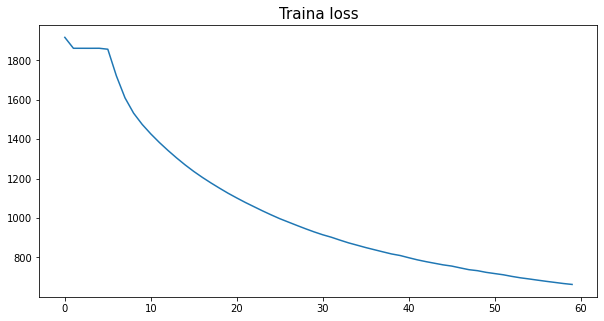

In [37]:
losses = train(enc_train, dec_train, encoder, decoder, dec_tokenizer, optimizer, BATCH_SIZE, EPOCHS=60)

Epoch 10: 100%|██████████| 480/480 [01:36<00:00,  4.98it/s, Loss 1.2799]


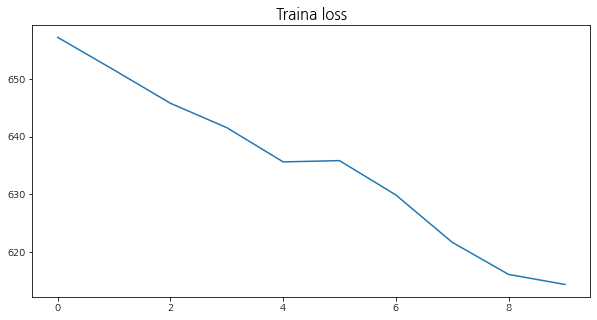

In [44]:
losses = train(enc_train, dec_train, encoder, decoder, dec_tokenizer, optimizer, BATCH_SIZE, EPOCHS=10)

Epoch 10: 100%|██████████| 480/480 [01:31<00:00,  5.27it/s, Loss 1.1959]


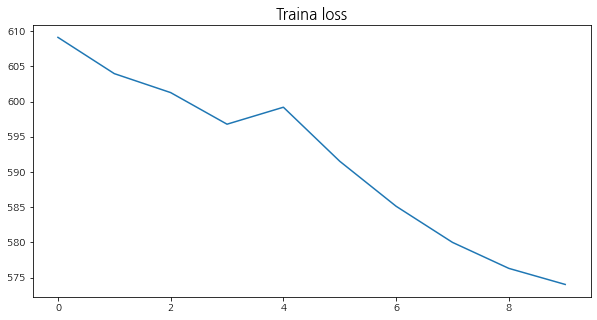

In [65]:
losses = train(enc_train, dec_train, encoder, decoder, dec_tokenizer, optimizer, BATCH_SIZE, EPOCHS=10)

## Step 5. 모델 평가
---

In [38]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [61]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(4,7))
    ax = fig.add_subplot(1, 1, 1)
#     ax.matshow(attention, cmap='viridis')
    cax = ax.matshow(attention, cmap='GnBu')
    fig.colorbar(cax, shrink=0.8)

    fontdict = {'fontsize': 14}
    plt.rc('font', family='NanumGothic')

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [62]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [63]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

Input: 오바마는 대통령이다 .
Predicted translation: but some people get underway at the cigar <end> 


/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


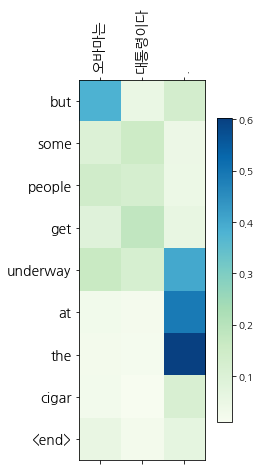

Input: 시민들은 도시 속에 산다 .
Predicted translation: roads provides branches <end> 


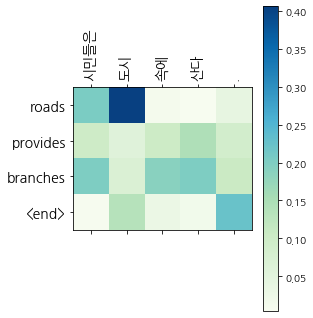

Input: 커피는 필요 없다 .
Predicted translation: i don t think anything are no one of things . <end> 


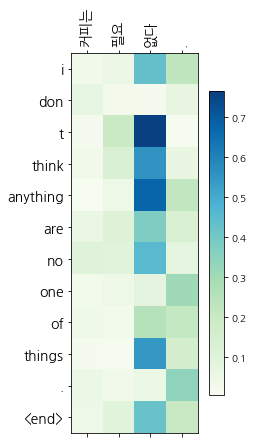

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: six snorkelers and a day . <end> 


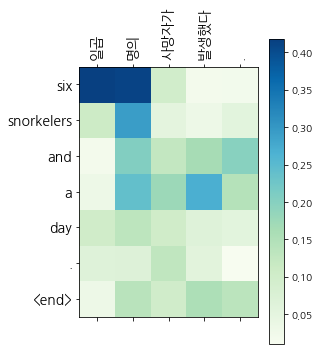

In [64]:
for sen in examples:
    translate(sen, encoder, decoder)